In [11]:
import torch
import numpy as np
import numbers
import math
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import scipy.stats as stats
from scipy.ndimage import uniform_filter1d

In [2]:
def make_sase(
    npoints: int,
    sparsity: float,
    bandwidth: float = 1.0,
    nshots: int = 1,
    center: float = 0.0,
    normalize = 'max',
):
    """
    Generate fake SASE spectra with tunable "sparsity", i.e. number of spikes per spectrum.
    Higher sparsity number indicates more spikes, lower indicates fewer.
    
    Args:
        npoints (int): number of points to generate for axis in range [-1., 1.]
        sparsity (float): a "sparsity" parameter for the SASE in number of spikes per bin
        bandwith (float): the Gaussian envelope width in FWHM on the range [-1., 1.]
        nshots (int): number of shots to generate
        modulate_power: whether to model power fluctuations (default False)
        normalize: we can normalize by 'l2', 'power', 'max', with default = 'max'. 'l2' makes it 
                    so that each shot has unit euclidean norm, 'power' ensures that
                    the sum of each shot is 1, and 'max' ensures that the peak spectral
                    intensity is 1 for the whole dataset. 'max' is default since it makes the 
                    most physical sense to me and results in the best correlation between
                    sparsity and coherence
    """

    axis = np.linspace(-1, 1, npoints).reshape(-1, 1)
    bandwidth = bandwidth / 2.355  # convert from FWHM
    envelope = stats.norm.pdf(axis, scale=bandwidth, loc=center)
    Xni = stats.gamma.rvs(
        a=sparsity * envelope, scale= 1, size=(len(axis), nshots)
    ).T
    
    if normalize == "l2":
        Xni /= np.sqrt((Xni**2).sum(-1))[:,None]
    elif normalize == "power":
        Xni /= Xni.sum(-1)[:,None]
    elif normalize == "max":
        Xni /= Xni.max()

    return uniform_filter1d(Xni,3,-1)

In [3]:
def first_moment(axis, specs):
    return (axis[None,:]*specs/(specs.sum(-1)[:,None])).sum(-1)

def thresh_clean(X, thresh=0.01):
    X = np.copy(X)
    Xm = X/X.max()
    mask = Xm<thresh
    X[mask] *= 0
    return X

def blank_shot_mask(X, thresh=0.01):
    Xm = X/X.max()
    return np.any(X>thresh, axis=-1)

def discrete_gaussian(kernel_size, dim, sigma, dtype=torch.float32):
    if isinstance(kernel_size, numbers.Number):
        kernel_size = [kernel_size] * dim
    if isinstance(sigma, numbers.Number):
        sigma = [sigma] * dim
    kernel = 1
    meshgrids = torch.meshgrid(
        [
            torch.arange(size, dtype=dtype)
            for size in kernel_size
        ]
    )
    for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
        mean = (size - 1) / 2
        kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                  torch.exp(-((mgrid - mean) / std) ** 2 / 2)
        
    # Make sure sum of values in gaussian kernel equals 1.
    kernel = kernel / torch.sum(kernel)
    return kernel

class GaussianSmoothing(torch.nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2, dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = discrete_gaussian(kernel_size, dim, sigma, dtype=self.dtype)
        
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

def batch_filter_2D(imgs, sigma, filter_size=5):
    """imgs interpreted to be a batch of images, with -1 dim being roi dim and -2 dim being out dim,
        -3 being batch dim"""
    assert imgs.dim() == 3
    assert filter_size % 2 > 0
    padlen = (filter_size - 1)//2
    smoother = GaussianSmoothing(1, filter_size, sigma, dim=2, dtype=imgs.dtype)
    inp = F.pad(imgs, (padlen, padlen, padlen, padlen), mode='constant')
    output = smoother(inp.unsqueeze(1)) #unsqueeze to insert channel dim
    return output

def add_readnoise(img, noise_in_photons):
    if torch.is_tensor(img):
        z = torch.empty_like(img).normal_()*noise_in_photons
        return img + z
    else:
        z = torch.empty_like(torch.from_numpy(img)).normal_()*noise_in_photons
        return (img + z).cpu().detach().numpy()

def add_poisson_noise(x, alpha: float):
    if torch.is_tensor(x):
        return torch.from_numpy(np.random.poisson(x.detach().cpu().numpy() * alpha)).type(x.dtype).to(x.device)
    else:
        return np.array(np.random.poisson(x * alpha), x.dtype)
    
def add_2D_cs_noise_to_vector_data(x, alpha: float, noise_in_photons: float, 
                                                     blur_radius_in_pixels: float, filter_size=5, roi_width=20,
                                                    debug=False):
    """
    x expected to be 2D, with shape N x D, i.e. shots by output pixels. The values in x are interpreted to be
    photon rates.
    
    This vector is expanded to N x D x roi_width. We adjust the rate according to a gaussian profile, along the
    spatial direction (i.e. the new expanded dimension) to simulate a focused von Hamos emission pattern. This
    should give variable rates of charge sharing effect across the roi.
    
    Then the photons (now treated as ADUs) blurred according to the specified blur_radius_in_pixels, which uses a
    gaussian blur.
    
    Then, read noise (gaussian noise) is added to that, with the amount specified by "noise_in_photons", which
    indicates that you should give a fractional photon as the unit, e.g. 1/8 of a photon is typical.
    
    Finally, the ROI dim is sum reduced to simulate integration over a spatial dimension in the usual von Hamos
    style of data collection.
    
    To skip any one of these 3 steps, you can set the corresponding control variable to some negative number. So,
    pure poisson = alpha > 0, noise_in_photons < 0, blur_radius_in_pixels < 0
    pure gaussian = alpha < 0, noise_in_photons >0,  blur_radius_in_pixels < 0
    """
    assert len(x.shape)==2
    assert filter_size % 2 > 0
    flag = False
    if not torch.is_tensor(x):
        flag = True
        x = torch.from_numpy(x)
    D = x.shape[-1]
    x = x.unsqueeze(-1).expand(-1, D, roi_width)/roi_width
    #this width (roi/6) makes the edge pixel about 50x weaker than center pixels
    f = discrete_gaussian(roi_width, 1, roi_width/6, dtype=x.dtype)
    x = f[None,None,:]*x #apply the filter to simulate focused light
    if alpha > 0:
        photons = add_poisson_noise(x, alpha)
        latent = x*alpha
    else:
        photons = x
        latent = x
    if debug:
        figure()
        imshow(photons[0,:,:])
    if blur_radius_in_pixels > 0:
        blurred_photons = batch_filter_2D(photons, blur_radius_in_pixels, filter_size=filter_size)
        blurred_latent = batch_filter_2D(latent, blur_radius_in_pixels, filter_size=filter_size)
    else:
        blurred_photons = photons.unsqueeze(1) #add channel dim
        blurred_latent = latent.unsqueeze(1)
    if debug:
        figure()
        imshow(blurred_photons[0,0,:,:])
    if noise_in_photons > 0:
        noisy_adu = add_readnoise(blurred_photons, noise_in_photons/np.sqrt(roi_width))
        latent_adu = blurred_latent
    else:
        noisy_adu = blurred_photons
        latent_adu = blurred_latent
    result = noisy_adu.sum(dim=-1)
    latent_result = latent_adu.sum(dim=-1)
    if flag:
        return result[:,0,:].numpy(), latent_result[:,0,:].numpy()
    else:
        return result[:,0,:], latent_result[:,0,:]

In [4]:
def simulate_detector_response(sase_shots,
                       herfd,
                       emission,
                       mean_photon_rate = 10,
                       read_noise = 1/4, 
                       cs_radius_in_pixels=1.,
                       batch_size = 40000):
    """ A quick and dirty simulation, where the rixs plane is just the outer product of the herfd spectrum 
        and the emission spectrum. Father, forgive me for these sins."""
    herfd = herfd[:,None] / herfd.max()
    emission = (emission[None,:]/emission.max())
    rixs = np.clip(herfd * emission, a_min=0., a_max=None)
#     sase_shots = sase_shots/np.sum(sase_shots, axis=1).mean()
    Y = sase_shots @ rixs
    
#     c = Y[:].mean() # sets mean photon rate to 1, so now mean_photon_rate is given to alpha
    # there seems to be memory issues on my machine associated with simulating many shots. So I limit it 
    # to batches of 40k shots.
    ys = TensorDataset(torch.from_numpy(Y))
    ys_loader = DataLoader(ys, batch_size=batch_size)
    Ycs = []
    for ys in ys_loader:
        Ycs.append(add_2D_cs_noise_to_vector_data(ys[0], alpha=mean_photon_rate, noise_in_photons=read_noise,
                                        blur_radius_in_pixels=cs_radius_in_pixels))
    Yc = np.concatenate([x[0].numpy() for x in Ycs],0)
    Lc = np.concatenate([x[1].numpy() for x in Ycs],0)
    # returning the sase_shots in case our sum normalization affected them, so that reconstruction algorithms
    # should now give the right answer. The last return is the ground truth with appropriate scaling adjustments
    # made so that it should match the reconstructed answer.
    return sase_shots, Yc, rixs, Lc

In [5]:
from matplotlib.pyplot import *
import h5py
import sys
sys.path.append('/home/fdfuller/work/dgp_iwvi_gpflow2/')
from dgp_iwvi_gpflow2.reference_spectra import *
%matplotlib notebook

In [6]:
# dname = 'clean_sorted_200mM_ferrocyanide_pink_all'
# # dname = 'finely_corrected_and_biased_pink'
# with h5py.File('/home/fdfuller/work/data/sacla2017/' + dname + '.h5','r') as fid:
#     inp_axis = np.array(fid['inp_axis'])
#     out_axis = np.array(fid['out_axis_binned'])
# #     print(fid.keys())
# #     Xpink = np.concatenate([np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64'), 
# #                             np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')],
# #                            0)
#     Xpinka = np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64')
#     Xpinkb = np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')
#     Xpink = np.concatenate([Xpinka, Xpinkb],0)
#     Xpink /= Xpink.max()
#     Xpink = np.clip(Xpink, a_min=0., a_max=None)
# #     Ypink = np.concatenate([np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64'),
# #                             np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')],0)
#     Ypinka = np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64')
#     Ypinkb = np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')
#     Ypink = np.concatenate([Ypinka, Ypinkb],0)
#     Ypink /= Ypink.max()

# mu1all = first_moment(inp_axis, Xpink)
# si = np.argsort(mu1all)
# Xpink_adj = Xpink[si,:][17000:187000,:]
# Ypink = Ypink[si,:][17000:187000,:]


dname = 'clean_sorted_200mM_ferrocyanide_pink_all'
# dname = 'finely_corrected_and_biased_pink'
with h5py.File('/home/fdfuller/work/data/sacla2017/' + dname + '.h5','r') as fid:
    inp_axis = np.array(fid['inp_axis'])
    out_axis = np.array(fid['out_axis_binned'])
#     print(fid.keys())
#     Xpink = np.concatenate([np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64'), 
#                             np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')],
#                            0)
    Xpinka = np.array(fid['X_by_first_sase_moment_cluster_a']).astype('float64')
    Xpinkb = np.array(fid['X_by_first_sase_moment_cluster_b']).astype('float64')
    Xpink = np.concatenate([Xpinka, Xpinkb],0)
    Xpink /= Xpink.max()
    Xpink = np.clip(Xpink, a_min=0., a_max=None)
#     Ypink = np.concatenate([np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64'),
#                             np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')],0)
    Ypinka = np.array(fid['Ybinned_by_first_sase_moment_cluster_a']).astype('float64')
    Ypinkb = np.array(fid['Ybinned_by_first_sase_moment_cluster_b']).astype('float64')
    Ypink = np.concatenate([Ypinka, Ypinkb],0)
    Ypink /= Ypink.max()

# filter out extreme first moment values
mu1all = first_moment(inp_axis, Xpink)
si = np.argsort(mu1all)
Xpink = Xpink[si,:][17000:187000,:]
Ypink = Ypink[si,:][17000:187000,:]

# no adjust old style dataset
Xpink_old_no_adj = np.copy(Xpink)
Ypink_old_no_adj = np.copy(Ypink)
Xpink_old_no_adj = np.clip(Xpink_old_no_adj, a_min=0., a_max=None)
mu1all_old_no_adj = first_moment(inp_axis, Xpink_old_no_adj)
siona = np.argsort(mu1all_old_no_adj)
Xpink_old_no_adj = Xpink_old_no_adj[siona,:]
Ypink_old_no_adj = Ypink_old_no_adj[siona,:]

# old way of producing a dataset
Xpink_old = np.copy(Xpink)
Ypink_old = np.copy(Ypink)
adj_old = Xpink_old.sum(-1)[:,None]*(0.00035)
Xpink_old_adj = np.clip(Xpink_old - adj_old, a_min=0., a_max=None)
mu1all_old = first_moment(inp_axis, Xpink_old_adj)
sio = np.argsort(mu1all_old)
Xpink_old = Xpink_old_adj[sio,:]
Ypink_old = Ypink_old[sio,:]


#limit the dynamic range of the SASE to 2 orders of magnitude
Xpink_thresh = thresh_clean(Xpink)

#remove blank shots
bsm = blank_shot_mask(Xpink_thresh)
Xpink = Xpink[bsm,:]
Xpink_thresh = Xpink_thresh[bsm,:]
Ypink = Ypink[bsm,:]

#collect a dataset that has no adjustment
Xpink_thresh_no_adj = np.clip(Xpink_thresh, a_min=0., a_max=None)
Ypink_thresh_no_adj = np.copy(Ypink)
mu1all_thresh_no_adj = first_moment(inp_axis, Xpink_thresh_no_adj)
sitna = np.argsort(mu1all_thresh_no_adj)
Ypink_thresh_no_adj = Ypink_thresh_no_adj[sitna,:][250:-250,:]
Xpink_thresh_no_adj = Xpink_thresh_no_adj[sitna,:][250:-250,:]

#remove elastic scatter from Xpink
adj = Xpink.sum(-1)[:,None]*(0.00035)
Xpink_adj = Xpink - adj
adj_t = Xpink_thresh.sum(-1)[:,None]*(0.00035)
Xpink_thresh_adj = Xpink_thresh - adj_t
Xpink_thresh_adj_new = Xpink_thresh + adj_t

#clamp Xpink
Xpink = np.clip(Xpink_adj, a_min = 0, a_max = None)
Xpink_thresh = np.clip(Xpink_thresh_adj, a_min = 0, a_max = None)
Xpink_thresh_new = np.clip(Xpink_thresh_adj_new, a_min = 0, a_max = None)

#resort according to first moment and re-trim
mu1all = first_moment(inp_axis, Xpink)
si = np.argsort(mu1all)
Xpink_unthresh = Xpink[si,:][250:-250,:]
Ypink_unthresh = Ypink[si,:][250:-250,:]

#resort according to first moment for threshed and re-trim
mu1all_thresh = first_moment(inp_axis, Xpink_thresh)
sit = np.argsort(mu1all_thresh)
Xpink_thresh = Xpink_thresh[sit,:][250:-250,:]
Ypink_thresh = Ypink[sit,:][250:-250,:]

#rejigger a new thresholded dataset to have *more* elastic scatter in it
mu1all_thresh_new = first_moment(inp_axis, Xpink_thresh_new)
sitn = np.argsort(mu1all_thresh_new)
Xpink_thresh_new = Xpink_thresh_new[sitn,:][250:-250,:]
Ypink_thresh_new = Ypink[sitn,:][250:-250,:]


In [7]:
def G(x, alpha):
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.sqrt(np.log(2) / np.pi) / alpha\
                             * np.exp(-(x / alpha)**2 * np.log(2))

def L(x, gamma):
    """ Return Lorentzian line shape at x with HWHM gamma """
    l = 1 / ((np.pi*gamma)*(1 + x**2/gamma**2))
    return l/l.max()

def static_profile_correction(X, inp_axis, center, width):
    return X*L(inp_axis - center, width/2)[None,:]

def reverse_static_profile_correction(X, inp_axis, center, width):
    return X/L(inp_axis - center, width/2)[None,:]

In [8]:
Xpink_old_no_adj_warp_high = reverse_static_profile_correction(Xpink_old_no_adj, inp_axis, 7.110, 0.075)
Ypink_old_no_adj_warp_high = np.copy(Ypink_old_no_adj)

Xpink_old_no_adj_warp_higher = reverse_static_profile_correction(Xpink_old_no_adj, inp_axis, 7.100, 0.100)
Ypink_old_no_adj_warp_higher = np.copy(Ypink_old_no_adj)

Xpink_old_no_adj_warp_low = reverse_static_profile_correction(Xpink_old_no_adj, inp_axis, 7.125, 0.075)
Ypink_old_no_adj_warp_low = np.copy(Ypink_old_no_adj)

<IPython.core.display.Javascript object>


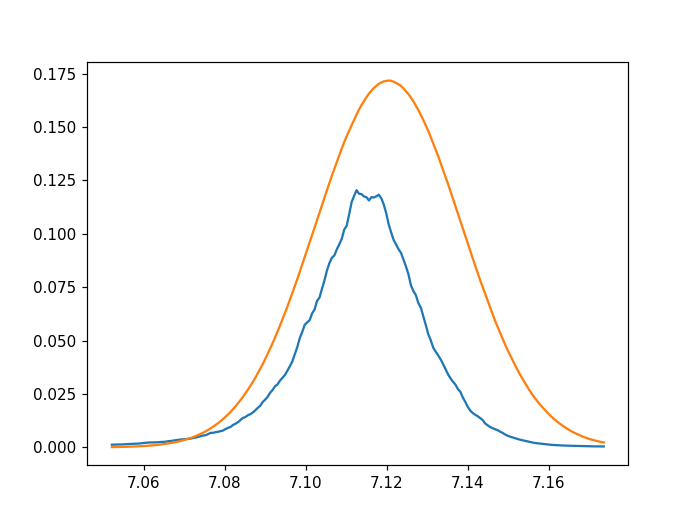

In [51]:
figure()
plot(inp_axis, Xpink_old_no_adj.mean(0))
plot(inp_axis, make_sase(npoints=200, sparsity=3.0, nshots=Xpink_old_no_adj.shape[0], center=75/200-0.5, bandwidth=0.7).mean(0))

In [55]:
Xpink_fake_low = make_sase(npoints=200, sparsity=2.0, nshots=Xpink_old_no_adj.shape[0], center=115/200-0.5, bandwidth=0.7)
Xpink_fake_high = make_sase(npoints=200, sparsity=2.0, nshots=Xpink_old_no_adj.shape[0], center=75/200-0.5, bandwidth=0.7)

<IPython.core.display.Javascript object>


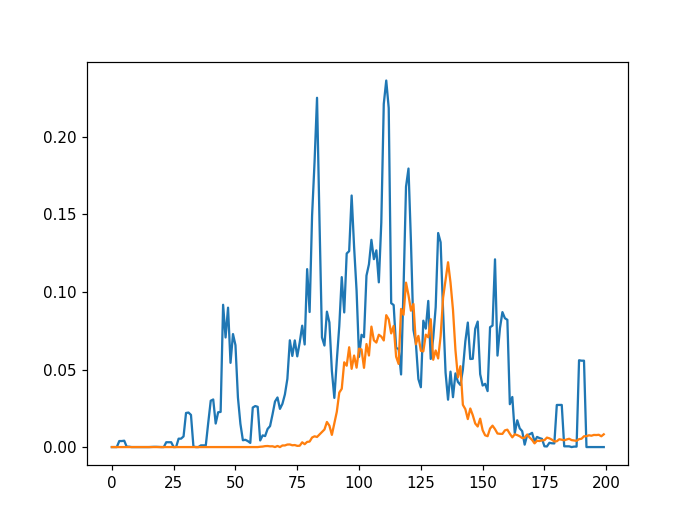

In [48]:
figure()
plot(fake_pink_high[57])
plot(Xpink[14])

In [9]:
# Xnorm_thresh, Ysim_thresh, ground_truth_thresh, latent_targets_thresh = simulate_detector_response(Xpink_thresh,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_thresh.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

# Xnorm_unthresh, Ysim_unthresh, ground_truth_unthresh, latent_targets_unthresh = simulate_detector_response(Xpink_unthresh,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_unthresh.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

# Xnorm_old, Ysim_old, ground_truth_old, latent_targets_old = simulate_detector_response(Xpink_old,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_old.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

# Xnorm_old_no_adj, Ysim_old_no_adj, ground_truth_old_no_adj, latent_targets_old_no_adj = \
#                                 simulate_detector_response(Xpink_old_no_adj,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_old_no_adj.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

# Xnorm_thresh_no_adj, Ysim_thresh_no_adj, ground_truth_thresh_no_adj, latent_targets_thresh_no_adj = \
#                                 simulate_detector_response(Xpink_thresh_no_adj,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_thresh_no_adj.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

# Xnorm_thresh_new, Ysim_thresh_new, ground_truth_thresh_new, latent_targets_thresh_new = \
#                             simulate_detector_response(Xpink_thresh_new,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_thresh_new.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

# Xnorm_fake_high, Ysim_fake_high, ground_truth_fake_high, latent_targets_fake_high = \
#                             simulate_detector_response(Xpink_fake_high,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_thresh_new.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

# Xnorm_fake_low, Ysim_fake_low, ground_truth_fake_low, latent_targets_fake_low = \
#                             simulate_detector_response(Xpink_fake_low,
#                                                           ferro_spline(inp_axis), 
#                                                           (500/2)*Ypink_thresh_new.mean(0),
#                                                           mean_photon_rate=1050,
#                                                           read_noise=1/5,
#                                                           cs_radius_in_pixels=0.42)

Xnorm_old_no_adj_warp_high, Ysim_old_no_adj_warp_high, ground_truth_old_no_adj_warp_high, \
            latent_targets_old_no_adj_warp_high = simulate_detector_response(Xpink_old_no_adj_warp_high,
                                                          ferro_spline(inp_axis), 
                                                          (500/2)*Ypink_old_no_adj_warp_high.mean(0),
                                                          mean_photon_rate=1050,
                                                          read_noise=1/5,
                                                          cs_radius_in_pixels=0.42)

Xnorm_old_no_adj_warp_higher, Ysim_old_no_adj_warp_higher, ground_truth_old_no_adj_warp_higher, \
            latent_targets_old_no_adj_warp_higher = simulate_detector_response(Xpink_old_no_adj_warp_higher,
                                                          ferro_spline(inp_axis), 
                                                          (500/2)*Ypink_old_no_adj_warp_higher.mean(0),
                                                          mean_photon_rate=1050,
                                                          read_noise=1/5,
                                                          cs_radius_in_pixels=0.42)

Xnorm_old_no_adj_warp_low, Ysim_old_no_adj_warp_low, ground_truth_old_no_adj_warp_low, \
            latent_targets_old_no_adj_warp_low = simulate_detector_response(Xpink_old_no_adj_warp_low,
                                                          ferro_spline(inp_axis), 
                                                          (500/2)*Ypink_old_no_adj_warp_low.mean(0),
                                                          mean_photon_rate=1050,
                                                          read_noise=1/5,
                                                          cs_radius_in_pixels=0.42)

<IPython.core.display.Javascript object>


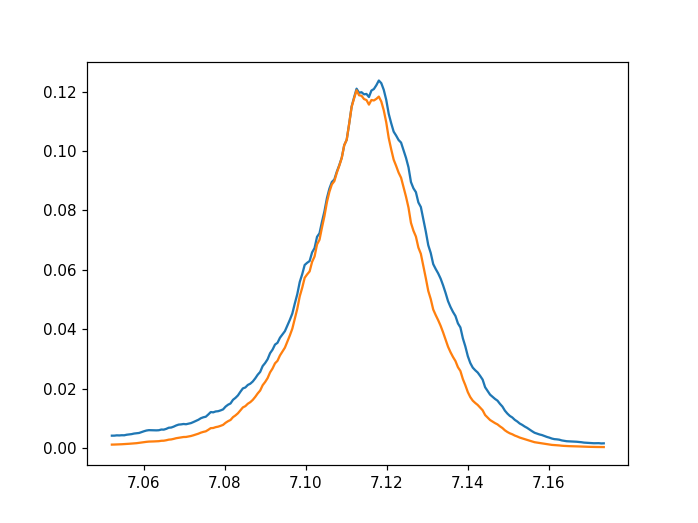

In [13]:
figure()
plot(inp_axis, Xnorm_old_no_adj_warp_high.mean(0))
plot(inp_axis, Xpink_old_no_adj.mean(0))

<IPython.core.display.Javascript object>


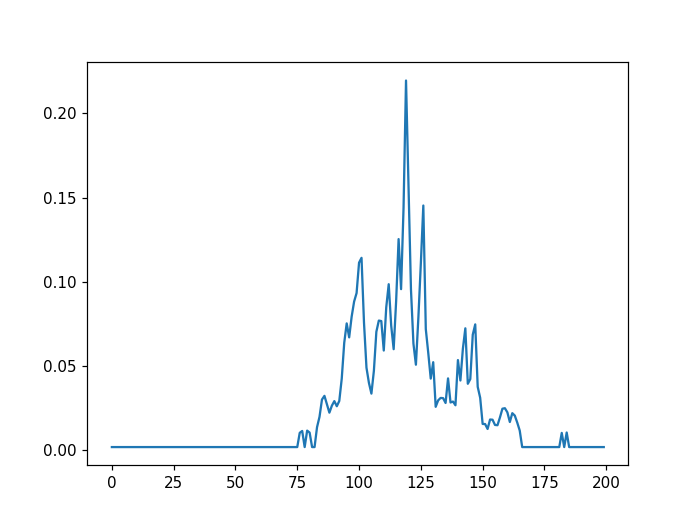

In [7]:
figure()
plot(Xpink_thresh_new[5030])

<IPython.core.display.Javascript object>


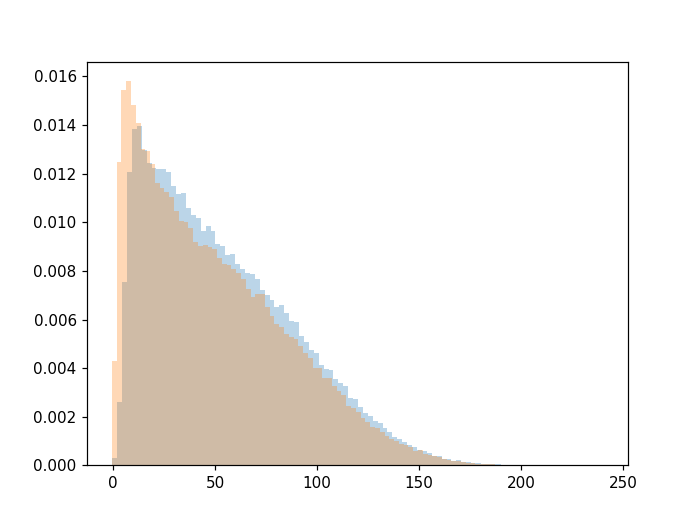

In [8]:
figure()
p = 13
hist(Ysim_thresh_new[:,p],100, density=True,alpha=0.3);
hist((500/2)*Ypink_thresh_new[:,p], 100, density=True,alpha=0.3);
# hist(latent_targets[:,p], 100, density=True,alpha=0.3);

<IPython.core.display.Javascript object>


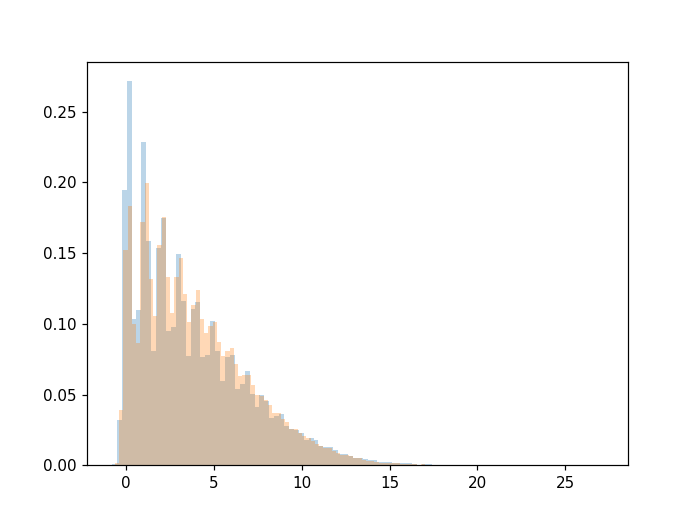

In [28]:
figure()
p = 40
hist(Ysim_thresh[:,p],100, density=True,alpha=0.3);
hist((500/2)*Ypink_thresh[:,p], 100, density=True,alpha=0.3);
# hist(latent_targets[:,p], 100, density=True,alpha=0.3);

<IPython.core.display.Javascript object>


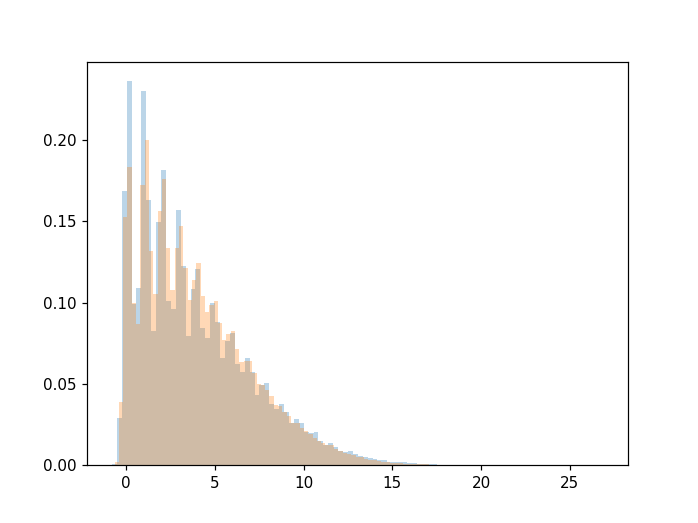

In [29]:
figure()
p = 40
hist(Ysim_unthresh[:,p],100, density=True,alpha=0.3);
hist((500/2)*Ypink_unthresh[:,p], 100, density=True,alpha=0.3);
# hist(latent_targets[:,p], 100, density=True,alpha=0.3);

<IPython.core.display.Javascript object>


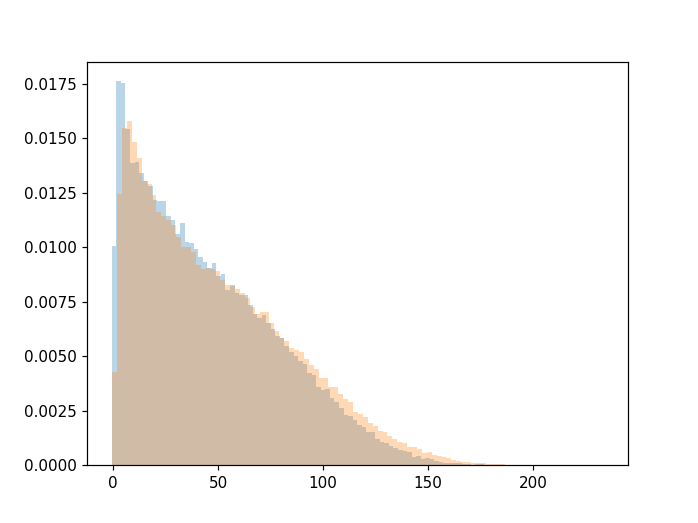

In [32]:
figure()
p = 13
hist(Ysim_thresh[:,p],100, density=True,alpha=0.3);
hist((500/2)*Ypink_thresh[:,p], 100, density=True,alpha=0.3);
# hist(latent_targets[:,p], 100, density=True,alpha=0.3);

<IPython.core.display.Javascript object>


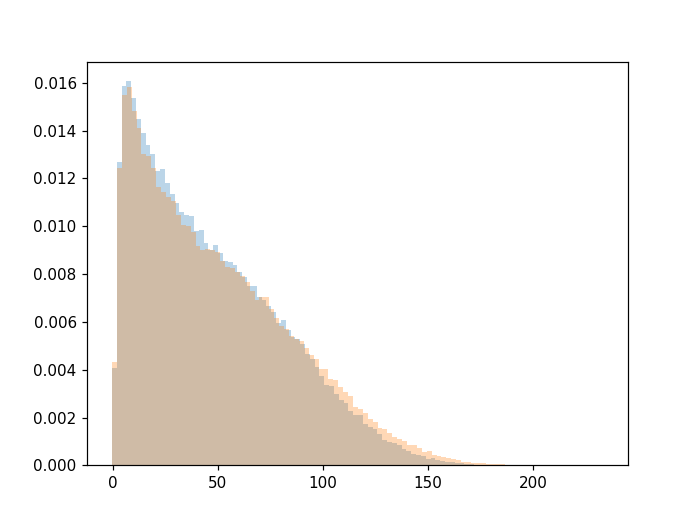

In [31]:
figure()
p = 13
hist(Ysim_unthresh[:,p],100, density=True,alpha=0.3);
hist((500/2)*Ypink_unthresh[:,p], 100, density=True,alpha=0.3);
# hist(latent_targets[:,p], 100, density=True,alpha=0.3);

In [34]:
p = 13
snr = (latent_targets_thresh[:,p].var() + latent_targets_thresh[:,p].mean()**2)/(Ysim_thresh[:,p].var() + Ysim_thresh[:,p].mean()**2)
print(snr)

0.9880728589071812


In [35]:
p = 13
snr = (latent_targets_unthresh[:,p].var() + latent_targets_unthresh[:,p].mean()**2)/(Ysim_unthresh[:,p].var() + Ysim_unthresh[:,p].mean()**2)
print(snr)

0.9882371694669266


In [10]:
# with h5py.File('./fake_data/trimmed_threshed_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_thresh)
#     fid.create_dataset('Y', data=Ysim_thresh/250)
#     fid.create_dataset('Yreal', data=Ypink_thresh)
#     fid.create_dataset('Xreal', data=Xpink_thresh)
#     fid.create_dataset('gt', data=ground_truth_thresh)

# with h5py.File('./fake_data/trimmed_threshed_new_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_thresh_new)
#     fid.create_dataset('Y', data=Ysim_thresh_new/250)
#     fid.create_dataset('Yreal', data=Ypink_thresh_new)
#     fid.create_dataset('Xreal', data=Xpink_thresh_new)
#     fid.create_dataset('gt', data=ground_truth_thresh_new)

# with h5py.File('./fake_data/totally_fake_high_sase_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_fake_high)
#     fid.create_dataset('Y', data=Ysim_fake_high/250)
#     fid.create_dataset('gt', data=ground_truth_fake_high)
    
# with h5py.File('./fake_data/totally_fake_low_sase_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_fake_low)
#     fid.create_dataset('Y', data=Ysim_fake_low/250)
#     fid.create_dataset('gt', data=ground_truth_fake_low)

with h5py.File('./fake_data/trimmed_old_unthreshed_no_adj_warped_high_data_run1.h5','w') as fid:
    fid.create_dataset('X', data=Xnorm_old_no_adj_warp_high)
    fid.create_dataset('Y', data=Ysim_old_no_adj_warp_high/250)
    fid.create_dataset('gt', data=ground_truth_old_no_adj_warp_high)
    
with h5py.File('./fake_data/trimmed_old_unthreshed_no_adj_warped_higher_data_run1.h5','w') as fid:
    fid.create_dataset('X', data=Xnorm_old_no_adj_warp_higher)
    fid.create_dataset('Y', data=Ysim_old_no_adj_warp_higher/250)
    fid.create_dataset('gt', data=ground_truth_old_no_adj_warp_higher)
    
with h5py.File('./fake_data/trimmed_old_unthreshed_no_adj_warped_low_data_run1.h5','w') as fid:
    fid.create_dataset('X', data=Xnorm_old_no_adj_warp_low)
    fid.create_dataset('Y', data=Ysim_old_no_adj_warp_low/250)
    fid.create_dataset('gt', data=ground_truth_old_no_adj_warp_low)

# with h5py.File('./fake_data/trimmed_threshed_no_adj_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_thresh_no_adj)
#     fid.create_dataset('Y', data=Ysim_thresh_no_adj/250)
#     fid.create_dataset('Yreal', data=Ypink_thresh_no_adj)
#     fid.create_dataset('Xreal', data=Xpink_thresh_no_adj)
#     fid.create_dataset('gt', data=ground_truth_thresh_no_adj)
    
# with h5py.File('./fake_data/trimmed_unthreshed_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_unthresh)
#     fid.create_dataset('Y', data=Ysim_unthresh/250)
#     fid.create_dataset('Yreal', data=Ypink_unthresh)
#     fid.create_dataset('Xreal', data=Xpink_unthresh)
#     fid.create_dataset('gt', data=ground_truth_unthresh)
    
# with h5py.File('./fake_data/trimmed_old_unthreshed_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_old)
#     fid.create_dataset('Y', data=Ysim_old/250)
#     fid.create_dataset('Yreal', data=Ypink_old)
#     fid.create_dataset('Xreal', data=Xpink_old)
#     fid.create_dataset('gt', data=ground_truth_old)
    
# with h5py.File('./fake_data/trimmed_old_unthreshed_no_adj_data_run1.h5','w') as fid:
#     fid.create_dataset('X', data=Xnorm_old_no_adj)
#     fid.create_dataset('Y', data=Ysim_old_no_adj/250)
#     fid.create_dataset('Yreal', data=Ypink_old_no_adj)
#     fid.create_dataset('Xreal', data=Xpink_old_no_adj)
#     fid.create_dataset('gt', data=ground_truth_old_no_adj)

In [16]:
def clean_mono(X, thresh=0.01):
    Xm = X/X.max()
    mask = Xm<thresh
    X[mask] *= 0
    return X

def blank_shot_mask(X, thresh=0.01):
    Xm = X/X.max()
    return np.any(X>thresh, axis=-1)

In [37]:
with h5py.File('/home/fdfuller/work/data/sacla2017/clean_sorted_200mM_ferrocyanide_mono.h5','r') as fid:
# with h5py.File('/reg/neh/home/fdfuller/projects/NN/sacla/FeIICN6_200mM.h5','r') as fid:
    Xmono = np.array(fid['X'])#[:,250:450]
    Xmono = np.clip(Xmono, a_min=0., a_max=None)
    Ymono = np.array(fid['Y'])#[:,100:350]
    inp_axis = np.array(fid['inp_axis'])
Xmono /= Xmono.max()
Ymono /= Ymono.max()

mu1mono = first_moment(inp_axis, Xmono)
si = np.argsort(mu1mono)
Xmono = Xmono[si,:][940:40940,:]
Ymono = Ymono[si,:][940:40940,:]
Xmono = clean_mono(Xmono)
bms = blank_shot_mask(Xmono)
Xmono = np.clip(Xmono[bms,:], a_min=0, a_max=None)
Ymono = Ymono[bms,:]

<IPython.core.display.Javascript object>


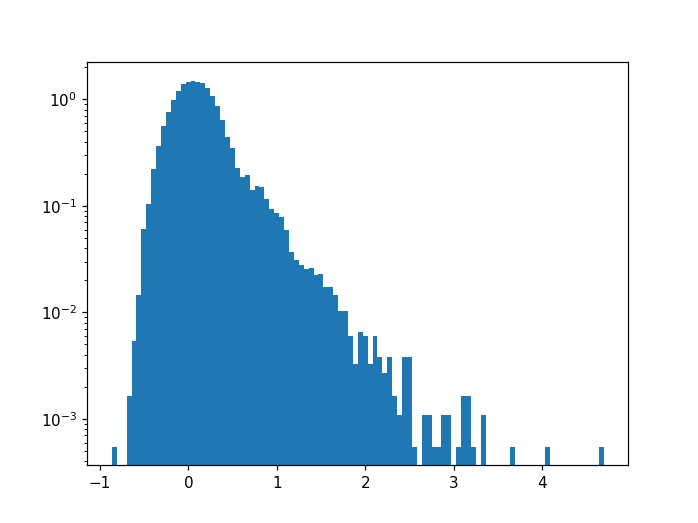

In [39]:
figure()
hist(40*Ymono[:,40],100,density=True)
yscale('log', nonposy='clip')

<IPython.core.display.Javascript object>


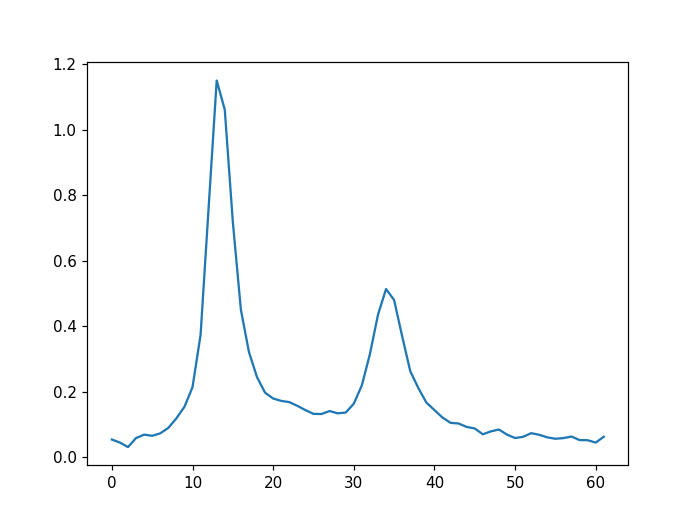

In [40]:
figure()
plot(40*Ymono.mean(0))

In [47]:
Xmono_normed, Ymono_sim, ground_truth_mono, latent_targets_mono = simulate_detector_response(Xmono,
                                                          ferro_spline(inp_axis), 
                                                          40*Ymono.mean(0),
                                                          mean_photon_rate=1050/3,
                                                          read_noise=1/5,
                                                          cs_radius_in_pixels=0.42)

<IPython.core.display.Javascript object>


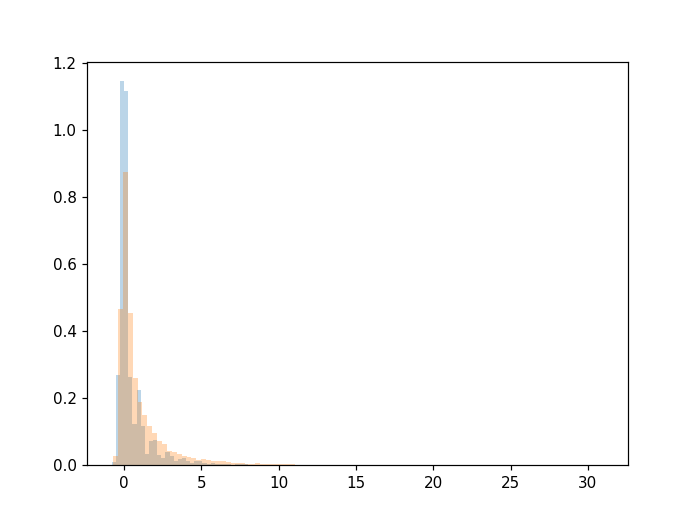

In [48]:
figure()
p = 13
hist(Ymono_sim[:,p],100, density=True,alpha=0.3);
hist(40*Ymono[:,p], 100, density=True,alpha=0.3);
# hist(latent_targets_mono[:,p], 100, density=True,alpha=0.3);

In [49]:
with h5py.File('./fake_data/trimmed_data_threshed_mono_run1.h5','w') as fid:
    fid.create_dataset('X', data=Xmono_normed)
    fid.create_dataset('Y', data=Ymono_sim/40)
    fid.create_dataset('gt', data=ground_truth_mono)
    fid.create_dataset('Yreal', data=Ymono)